#  This document is the exploratory data analysis for problems of anomaly with some of Sysmex's analyzers

## Part 1: Exploratory Data Analysis

This part is to explore data, transform and understand the data provided by Sysmex

In [2]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split 

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
qc_data = pd.read_csv('~/downloads/Specific QC Lot Number Results.csv', header =None)
qc_data.columns =['product_id', 'qc_lot', 'time', 'w-x', 'w-y', 'w-z']
machine_data = pd.read_excel('~/downloads/Reference Set A Result Set.xlsx')


In [4]:
machine_data.columns=['Prod_ID', 'Upgrade_Date', 'IPU_Ver', 'Ser_No', 'Model_ID']
qc_data.columns =['Prod_ID', 'QC_Lot', 'QC_Time', 'W-X', 'W-Y', 'W-Z']





In [5]:
print('number of products in machine data: {:32,d}'.format(len(np.unique(machine_data['Prod_ID']))))
print('number of records in machine data:  {:32,d}'.format( len((machine_data['Prod_ID']))))
print('number of products in QC data:      {:32,d}'.format( len(np.unique(qc_data['Prod_ID']))))
print('number of records in QC data:       {:32,d}'.format( len((qc_data['Prod_ID']))))

print('number of records in QC data with zero W-X data {:20,d}'.format( np.sum((qc_data['W-X']==0))))
print('number of records in QC data with zero W-Y data {:20,d}'.format(  np.sum((qc_data['W-Y']==0))))
print('number of records in QC data with zero W-Z data {:20,d}'.format(  np.sum((qc_data['W-Z']==0))))

print('number of records in QC data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((qc_data['W-X']==0)&(qc_data['W-Y']==0)&(qc_data['W-Z']==0))))

number of products in machine data:                            3,376
number of records in machine data:                             3,468
number of products in QC data:                                 3,807
number of records in QC data:                              2,435,412
number of records in QC data with zero W-X data               18,127
number of records in QC data with zero W-Y data               18,078
number of records in QC data with zero W-Z data               18,090
number of records in QC data with zero W-Z, W-Y, W-Z data     18,071


## Clean up data and create a joined dataset
In this step, we clean out records where W-X, W-Y, W-Z are all zeros. Also, we temporarily remove historical of software upgrade for each product ID just to keep one record for one machine with the latest software version then merge with QC data to create consolidated machine_qc dataset for analysis purpose

In [6]:
clean_qc_data = qc_data[((qc_data['W-X']!=0)&(qc_data['W-Y']!=0)&(qc_data['W-Z']!=0))]
machine_data = machine_data.sort_values(by =['Prod_ID', 'Upgrade_Date'], ascending = [True, True])
clean_qc_data['Prod_ID'] = clean_qc_data['Prod_ID'].astype(str)

clean_qc_data['QC_Time'] = pd.to_datetime(clean_qc_data['QC_Time'])

machine_data['Prod_ID'] = machine_data['Prod_ID'].astype(str)

machine_data['Upgrade_Date'] = pd.to_datetime(machine_data['Upgrade_Date'])


unique_machine_data=machine_data.drop_duplicates(subset='Prod_ID', keep ='first')
qc_machine_data = pd.merge(clean_qc_data, unique_machine_data, how ='left')




print('number of records for clean QC data:       {:32,d}'.format(len(clean_qc_data['Prod_ID'])))
print('number of records for unique machine data: {:32,d}'.format(len(unique_machine_data['Prod_ID'])))
print('number of records in consol data set       {:32,d}'.format(len(qc_machine_data['Prod_ID'])))

/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of records for clean QC data:                              2,417,282
number of records for unique machine data:                            3,376
number of records in consol data set                              2,417,282


There're records with null values due to missing master machine records

In [23]:
np.sum(qc_machine_data.isnull())

Prod_ID         0
QC_Lot          0
QC_Time         0
W-X             0
W-Y             0
W-Z             0
Upgrade_Date    0
IPU_Ver         0
Ser_No          0
Model_ID        0
dtype: int64

In [8]:
qc_machine_data=qc_machine_data.dropna()
qc_machine_data = qc_machine_data.sort_values(['QC_Lot', 'Prod_ID','QC_Time'], ascending = [True, True, True])


In [10]:


transformed_qc_machine_data = qc_machine_data[['QC_Lot', 'W-X', 'W-Y', 'W-Z', 'IPU_Ver', 'Model_ID']]
transformed_qc_machine_data = pd.get_dummies(transformed_qc_machine_data, columns =['IPU_Ver', 'Model_ID', 'QC_Lot']).values


In [11]:
train_data = transformed_qc_machine_data[0:800000]
test_data = transformed_qc_machine_data[800000:]

In [61]:
## Function to return a list of products that has more than one IPU versions
# def get_multi_IPU():
#     multi_ipu_machine = pd.DataFrame(columns = machine_data.columns)
#     Unique_Prod_ID = np.unique(machine_data.Prod_ID)
#     for prod_id in Unique_Prod_ID:
#         k = machine_data[machine_data.Prod_ID ==prod_id]
#         if k.shape[0]>1:
#             multi_ipu_machine = multi_ipu_machine.append(k)
#     multi_ipu_machine.sort_values(['Prod_ID', 'Upgrade_Date'], ascending = [False, False])
#     return multi_ipu_machine

def get_IPU_Ver(prod_id, tran_date):
    machine_mini_list = machine_data[machine_data['Prod_ID'] == prod_id]
    t = machine_mini_list.shape[0]
    if t ==0: return None
    k=0
#     print(machine_mini_list.shape)
#     print('hello')
    for i in range(t):
#         print('before print date')
#         print('date is', machine_mini_list.values[i,1])
        if machine_mini_list.Upgrade_Date.iloc[i] < tran_date: k=i
    
    return machine_mini_list.IPU_Ver.iloc[k]

#get_IPU_Ver('125862',pd.to_datetime('2017-01-19'))
qc_machine_data.head()


IPU_Ver =[]
for i in range(qc_machine_data.shape[0]):
    prod_id = qc_machine_data['Prod_ID'].iloc[i]
    tran_date = qc_machine_data.QC_Time.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

qc_machine_data['IPU_Ver'] = IPU_Ver
    
# print(prod_id)

In [12]:
qc_machine_data.describe(include =['O'])

,Prod_ID,QC_Lot,IPU_Ver,Ser_No,Model_ID
count,2199325,2199325,2199325,2199325,2199325
unique,3321,23,10,3319,4
top,155786,QC-70371102,00-16 (Build 7),21709,XN-10
freq,2148,190338,1948948,2148,2119867


In [63]:
qc_machine_data[qc_machine_data.Prod_ID =='125862']

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,Upgrade_Date,IPU_Ver,Ser_No,Model_ID
121,125862,QC-70371101,2017-03-16 07:57:51,1763,1184,1247,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
122,125862,QC-70371101,2017-03-22 09:39:57,1761,1181,1274,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
123,125862,QC-70371101,2017-03-22 09:49:16,1757,1202,1271,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
124,125862,QC-70371101,2017-03-22 10:07:43,1760,1198,1265,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
125,125862,QC-70371101,2017-03-22 10:25:11,1748,1173,1254,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
126,125862,QC-70371101,2017-03-22 10:41:21,1751,1190,1261,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
127,125862,QC-70371101,2017-03-22 10:49:25,1761,1158,1278,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
128,125862,QC-70371101,2017-03-22 11:43:44,1751,1177,1263,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
129,125862,QC-70371101,2017-03-24 12:23:36,1765,1215,1261,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
130,125862,QC-70371101,2017-03-24 13:08:49,1759,1185,1250,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20


In [13]:
qc_machine_data[['Upgrade_Date', 'QC_Time']].dropna().describe()

,Upgrade_Date,QC_Time
count,2199325,2199325
unique,3303,1851490
top,2017-05-19 04:00:57.837000,2017-05-18 07:32:35
freq,3310,8
first,2016-11-25 14:33:00.117000,2017-01-06 10:36:47
last,2017-05-24 14:04:56.943000,2017-05-31 08:28:32


In [14]:
qc_machine_data['IPU_Ver'].value_counts()

00-16 (Build 7)      1948948
00-19D (Build 13)     121243
00-17A (Build 1)       36938
00-19C (Build 1)       35064
00-18 (Build 4)        18534
00-19D (Build 12)      17299
00-19D (Build 9)        9379
00-19 (Build 9)         7757
00-15 (Build 5)         4116
00-20 (Build 8)           47
Name: IPU_Ver, dtype: int64

In [16]:
qc_machine_data.groupby('IPU_Ver')['Prod_ID'].describe().unstack()

,count,unique,top,freq
IPU_Ver,,,,
00-15 (Build 5),4116,7,148431,1128
00-16 (Build 7),1948948,2761,155786,2148
00-17A (Build 1),36938,83,139687,1161
00-18 (Build 4),18534,30,150007,1030
00-19 (Build 9),7757,11,127576,1553
00-19C (Build 1),35064,42,137876,1577
00-19D (Build 12),17299,37,169226,658
00-19D (Build 13),121243,341,121288,1487
00-19D (Build 9),9379,8,160464,1300


In [17]:
def count_unique(x):
    np_arr = x.values
    output = []
    for i in range(np_arr.shape[1]):
        output.append(len(np.unique(np_arr[:,i])))
    return  pd.DataFrame(np.array(output).reshape(-1,len(x.columns)), columns = x.columns)

qc_machine_data.groupby(['IPU_Ver', 'QC_Lot'])['Prod_ID', 'Model_ID'].apply(count_unique)

Prod_ID  Model_ID
IPU_Ver           QC_Lot                          
00-15 (Build 5)   QC-70371101 0        2         1
                  QC-70371102 0        2         1
                  QC-70371103 0        2         1
                  QC-70371301 0        3         1
                  QC-70371302 0        3         1
                  QC-70381101 0        2         1
                  QC-70381102 0        2         1
                  QC-70381103 0        2         1
                  QC-70391101 0        3         1
                  QC-70391102 0        3         1
                  QC-70391103 0        3         1
                  QC-70931101 0        2         1
                  QC-70931102 0        2         1
                  QC-70931103 0        2         1
                  QC-70931301 0        3         1
                  QC-70931302 0        3         1
                  QC-70941101 0        2         1
                  QC-70941102 0        2         1
                  QC-70941103 0        2         1
                  QC-70951101 0        3         1
                  QC-70951102 0        3         1
                  QC-70951103 0        3         1
00-16 (Build 7)   QC-70371101 0     1343         2
                  QC-70371102 0     1346         2
                  QC-70371103 0     1346         2
                  QC-70371301 0     1620         2
                  QC-70371302 0     1620         2
                  QC-70371601 0        1         1
                  QC-70381101 0     1378         1
                  QC-70381102 0     1383         1
...                                  ...       ...
00-19D (Build 13) QC-70371302 0      145         3
                  QC-70381101 0      104         3
                  QC-70381102 0      104         3
                  QC-70381103 0      104         3
                  QC-70391101 0       17         2
                  QC-70391102 0       17         2
                  QC-70391103 0       17         2
                  QC-70931101 0      189         3
                  QC-70931102 0      195         3
                  QC-70931103 0      195         3
                  QC-70931301 0      143         3
                  QC-70931302 0      145         3
                  QC-70941101 0      117         3
                  QC-70941102 0      118         3
                  QC-70941103 0      117         3
                  QC-70951101 0       15         2
                  QC-70951102 0       17         2
                  QC-70951103 0       18         2
00-19D (Build 9)  QC-70371101 0        8         1
                  QC-70371102 0        8         1
                  QC-70371103 0        8         1
                  QC-70931101 0        8         1
                  QC-70931102 0        8         1
                  QC-70931103 0        8         1
00-20 (Build 8)   QC-70391101 0        1         1
                  QC-70391102 0        1         1
                  QC-70391103 0        1         1
                  QC-70951101 0        1         1
                  QC-70951102 0        1         1
                  QC-70951103 0        1         1

[177 rows x 2 columns]

In [141]:
np.corrcoef(qc_machine_data[qc_machine_data.Prod_ID == '155786']['W-X'],qc_machine_data[qc_machine_data.Prod_ID == '155786']['W-Y']) 

array([[ 1.        ,  0.94977836],
       [ 0.94977836,  1.        ]])

In [58]:
import random as rd
max_ind = train_data.shape[0]
def sm_next_batch(batch_size, n_steps):
    X = np.empty([batch_size*n_steps, 40])
    Y = np.empty([batch_size*n_steps, 3])
    for i in range(batch_size):
        start = rd.randint(0, max_ind-n_steps-1)
        ys1 = train_data[start: start+n_steps]
        ys2 = train_data[start+1: start+n_steps+1,0:3]
        np.append(X, ys1)
        np.append(X, ys2)
    
    return X.reshape(-1, n_steps, 40), ys2.reshape(-1, n_steps, 3)

max_test_ind = test_data.shape[0]
def sm_test_next_batch(batch_size, n_steps):
    X = np.empty([batch_size*n_steps, 40])
    Y = np.empty([batch_size*n_steps, 3])
    for i in range(batch_size):
        start = rd.randint(0, max_ind-n_steps-1)
        ys1 = test_data[start: start+n_steps]
        ys2 = test_data[start+1: start+n_steps+1,0:3]
        np.append(X, ys1)
        np.append(X, ys2)

    
    return X.reshape(-1, n_steps, 40), ys2.reshape(-1, n_steps, 3)

In [59]:
tf.reset_default_graph()

n_steps = 120
n_inputs = 40
n_neurons = 100
n_outputs = 3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [60]:
n_iterations = 2000
sm_batch_size = 50
sm_n_steps = 120
sm_test_n_steps =20

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = sm_next_batch(sm_batch_size, sm_n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_test, Y_test = sm_test_next_batch(1, sm_n_steps)
    y_pred = sess.run(outputs, feed_dict={X: X_test})


0 	MSE: nan
100 	MSE: nan
200 	MSE: nan
300 	MSE: nan


KeyboardInterrupt: 

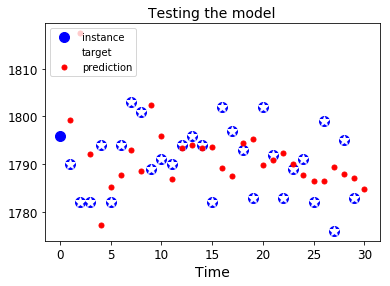

In [44]:
test_size=30

plt.title("Testing the model", fontsize=14)
plt.plot(np.arange(0,test_size,1), X_test[0,0:test_size,0], "bo", markersize=10, label="instance")
plt.plot(np.arange(1,test_size+1,1), Y_test[0,:,0][0:test_size], "w*", markersize=10, label="target")
plt.plot(np.arange(1,test_size+1,1), y_pred[0,:,0][0:test_size], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")



In [1]:
test_size=60

plt.title("Testing the model Y", fontsize=14)
plt.plot(np.arange(0,test_size,1), X_test[0,0:test_size,0], "bo", markersize=10, label="instance")
plt.plot(np.arange(1,test_size+1,1), Y_test[0,:,0][0:test_size], "w*", markersize=10, label="target")
plt.plot(np.arange(1,test_size+1,1), y_pred[0,:,0][0:test_size], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

NameError: name 'plt' is not defined

In [43]:
test_data.shape

(1399325, 40)

In [85]:
mean_x = qc_machine_data
mean_x = mean_x[['W-X','W-Y','W-Z','QC_Time']]

In [86]:
date = []
for i in range(mean_x.shape[0]):
    date.append(mean_x.iloc[i].QC_Time.date())
mean_x.QC_Time = date


/Users/giang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(array([ 17.,  12.,  37.,  19.,   0.,  30.,   0.,   0.,   2.,   1.]),
 array([ 1713.31707317,  1719.46631823,  1725.6155633 ,  1731.76480836,
         1737.91405343,  1744.06329849,  1750.21254355,  1756.36178862,
         1762.51103368,  1768.66027875,  1774.80952381]),
 <a list of 10 Patch objects>)

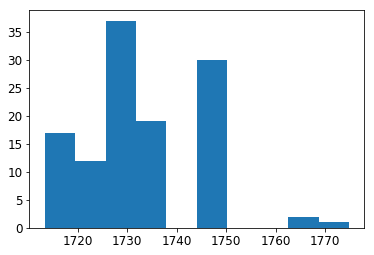

In [89]:
mean = mean_x.groupby('QC_Time')['W-X'].mean()
plt.hist(mean)


In [83]:
y

Prod_ID,121288,121289,124722,125862,125942,125947,125948,125997,125998,126163,...,128732,128733,128804,128810,128811,128891,128892,128907,128950,129068
QC_Time,,,,,,,,,,,,,,,,,,,,,
1,1257.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1272.428571,1295.666667,1281.333333,NaN,1248.000000,1267.333333,1262.000000,1261.666667,1243.333333,1237.000000,...,NaN,NaN,1243.777778,1269.400000,1239.560000,1249.857143,1245.571429,1225.000000,NaN,1240.090909
3,1272.764706,1300.400000,1292.000000,1262.4,1246.400000,1262.200000,1240.357143,1263.000000,1239.200000,1243.096774,...,1263.560606,1236.222222,1240.681818,1273.658537,1241.390244,1261.549451,1251.769231,1230.934783,NaN,1253.298246
4,1274.190476,1302.250000,1287.333333,1256.0,1252.571429,1262.000000,1246.000000,1272.333333,1241.000000,1242.450000,...,1264.661290,1240.750000,1245.828571,1278.673913,1247.434783,1262.555556,1258.472527,1245.650000,1261.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1276.000000,NaN,NaN,NaN,NaN,NaN,NaN
